In [1]:
import numpy as np 
import pandas as pd
import os
import cv2
# visualization
import matplotlib.pyplot as plt
from matplotlib import patches as patches
# plotly offline imports
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
from plotly import subplots
import plotly.express as px
import plotly.figure_factory as ff
from plotly.graph_objs import *
from plotly.graph_objs.layout import Margin, YAxis, XAxis
init_notebook_mode()
import glob as glob
# frequent pattern mining
from mlxtend.frequent_patterns import fpgrowth

In [2]:
train_path = '../dataset/idd20k_lite/leftImg8bit/train/'
val_path = '../dataset/idd20k_lite/leftImg8bit/val/'
test_path = '../dataset/idd20k_lite/leftImg8bit/test/'
train_df=pd.read_csv('../dataset/train.csv').fillna(-1)
val_df=pd.read_csv('../dataset/val.csv').fillna(-1)

In [3]:
print('Total number of images: %s' % len(train_df['ImageId'].unique()))
print('Images with at least one label: %s' % len(train_df[train_df['EncodedPixels'] != -1]['ImageId'].unique()))

Total number of images: 1380
Images with at least one label: 1380


In [4]:
#diffreent type of classes in our dataset 
train_df['ClassId'].unique()

array([  0,   1,   2,   3,   4,   5,   6, 255])

In [5]:
#  create a dict with class id and encoded pixels and group all the defaults per image
train_df['Label_EncodedPixels'] = train_df.apply(lambda row: (row['ClassId'], row['EncodedPixels']), axis = 1)

In [6]:
train_df[0:100]

Unnamed: 0     ImageId  ClassId  \
0            0      330189        0   
1            1      330189        1   
2            2      330189        2   
3            3      330189        3   
4            4      330189        4   
..         ...         ...      ...   
95          95      662718      255   
96          96  frame58999        0   
97          97  frame58999        1   
98          98  frame58999        2   
99          99  frame58999        3   

                                        EncodedPixels  \
0   30541 2 4 4 1 3 8 1 288 1 5 21 1 2 1 1 225 10 ...   
1   43443 3 635 1 319 2 318 3 317 3 317 4 316 4 31...   
2   26319 2 318 2 318 4 316 5 314 5 315 4 316 4 31...   
3   19614 25 293 30 289 32 288 33 286 34 286 35 28...   
4   13200 3 317 5 315 6 314 9 311 9 311 9 311 9 25...   
..                                                ...   
95                                                 -1   
96  37270 1 312 1 2 2 1 2 316 1 319 1 308 7 1 9 30...   
97  38232 1 966 1 321 1 321 1 320 1 217 2 102 2 20...   
98                                                 -1   
99  34356 12 303 1 4 12 302 18 302 18 302 18 270 7...   

                                  Label_EncodedPixels  
0   (0, 30541 2 4 4 1 3 8 1 288 1 5 21 1 2 1 1 225...  
1   (1, 43443 3 635 1 319 2 318 3 317 3 317 4 316 ...  
2   (2, 26319 2 318 2 318 4 316 5 314 5 315 4 316 ...  
3   (3, 19614 25 293 30 289 32 288 33 286 34 286 3...  
4   (4, 13200 3 317 5 315 6 314 9 311 9 311 9 311 ...  
..                                                ...  
95                                          (255, -1)  
96  (0, 37270 1 312 1 2 2 1 2 316 1 319 1 308 7 1 ...  
97  (1, 38232 1 966 1 321 1 321 1 320 1 217 2 102 ...  
98                                            (2, -1)  
99  (3, 34356 12 303 1 4 12 302 18 302 18 302 18 2...  

[100 rows x 5 columns]

In [7]:
#groupby imageid and the list contraining the encoded maps
label_type_per_image = train_df[train_df['EncodedPixels']!=-1]['ClassId'].value_counts()
label_type_per_image

5      1403
4      1402
0      1402
6      1390
3      1377
2      1261
1      1074
255     904
Name: ClassId, dtype: int64

In [8]:
# now we have the data ready lets plot them to answer our questions
trace1 = Bar(x=label_type_per_image.index, y=label_type_per_image.values, name = 'Frequency of Different Clouds')
fig = subplots.make_subplots(rows=1, cols=1)
fig.append_trace(trace1, 1, 1)
fig['layout'].update(height=400, width=900, title='Distribution of number of images per class')
iplot(fig)


#background class seems to be less in the images. 

In [9]:
grouped_EncodedPixels = train_df.groupby('ImageId')['Label_EncodedPixels'].apply(list)
labels_per_image_count = grouped_EncodedPixels.apply(lambda x: len([x[0] for x in x if x[1]!=-1])).value_counts()
# now we have the data ready lets plot them to answer our questions
trace0 = Bar(x=labels_per_image_count.index, y=labels_per_image_count.values, name = 'Number of Cloud Types Per Image')
fig = subplots.make_subplots(rows=1, cols=1)
fig.append_trace(trace0, 1, 1)
fig['layout'].update(height=400, width=900, title='Label Count and Frequency Per Image')
iplot(fig)

Max no of classes = 8 
There are some images with multiple image Ids in the dataset. So there are certain outliers. 

In [10]:
def rle2mask(rle, width, height):
    mask= np.zeros(width* height)
    if rle == ' -1' or rle == '-1':
        return mask.reshape(width,height)

    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        current_position += start
        mask[current_position:current_position+lengths[index]] = 255
        current_position += lengths[index]

    return mask.reshape(width, height)

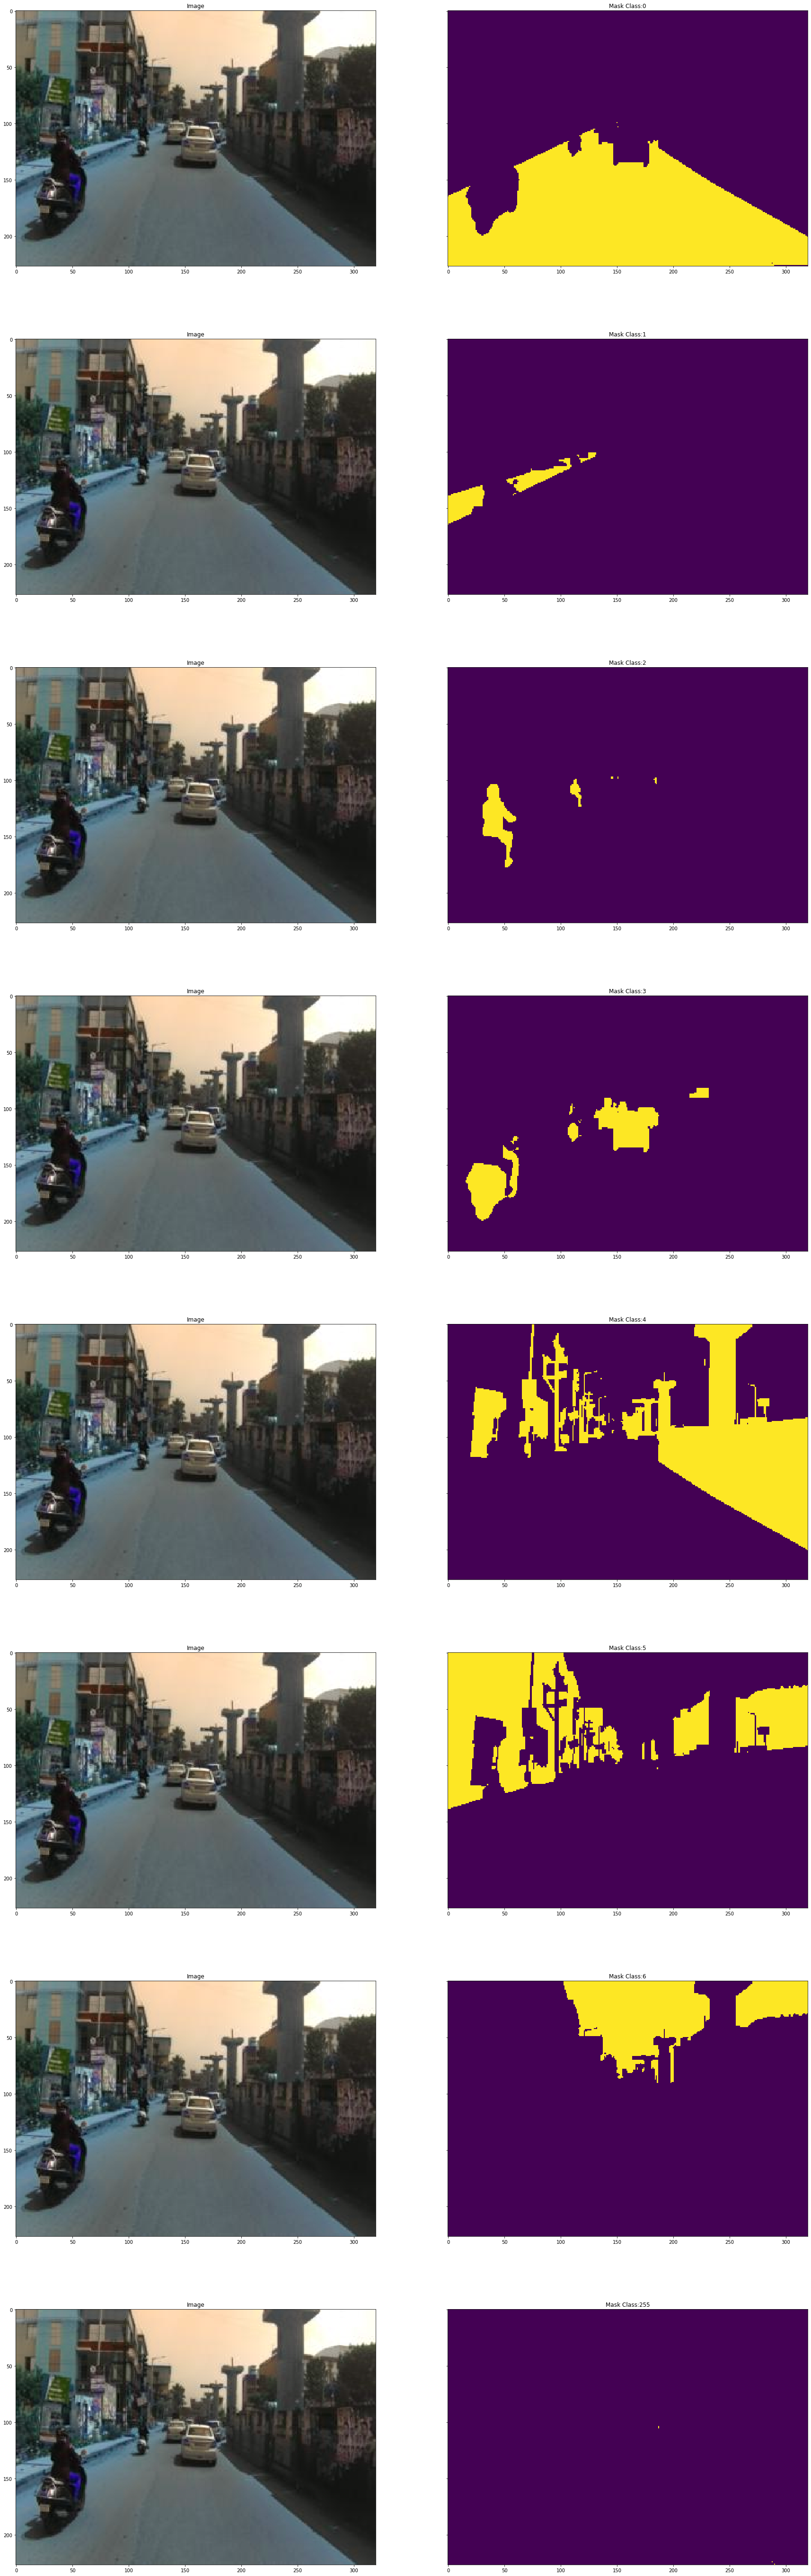

In [11]:
#plot a single image and mask to get an idea
train_fns = glob.glob(train_path+"*/*.jpg")
val_fns = glob.glob(val_path+"*/*.jpg")
test_fns = glob.glob(test_path+"*/*.jpg")
class_idx_list=[0,1,2,3,4,5,6,255]
fig, ax = plt.subplots(nrows=8, ncols=2, sharey=True, figsize=(30,100))
for i,class_idx in enumerate(class_idx_list):
    image_idx=150
    image_id=train_fns[image_idx].split('/')[-1].split('.')[0].split('_')[0]
    img = cv2.imread(train_fns[image_idx])
    h,w,c=img.shape
    encoding=train_df.loc[(train_df['ImageId'] == image_id) & (train_df['ClassId'] == class_idx)]['EncodedPixels']
    encoding=encoding[encoding.index[0]]
    if encoding==-1:
        print("true")
        mask=np.zeros((h,w))
    else:
        mask=rle2mask(encoding,h,w)

    ax[i][0].imshow(img)
    ax[i][0].title.set_text('Image')
    ax[i][1].imshow(mask)
    ax[i][1].title.set_text('Mask Class:'+ str(class_idx))

In [12]:
#plotting multiple segmentation masks on an image
# import data augmentation
import imgaug as ia
from imgaug import augmenters as iaa
# import segmentation maps from imgaug
from imgaug.augmentables.segmaps import SegmentationMapOnImage
import imgaug.imgaug

In [13]:
def create_segmentation_overlay(image_idx):
    image = cv2.imread(train_fns[image_idx])
    segmap = np.zeros((image.shape[0], image.shape[1]), dtype=np.int32)
    class_idx_list=[0,1,2,3,4,5,6,255]
    image_id=train_fns[image_idx].split('/')[-1].split('.')[0].split('_')[0]
    h,w,c=img.shape
    for i,class_idx in enumerate(class_idx_list):
        encoding=train_df.loc[(train_df['ImageId'] == image_id) & (train_df['ClassId'] == class_idx)]['EncodedPixels']
        encoding=encoding[encoding.index[0]]
        if encoding==-1:
            print("true")
            mask=np.zeros((h,w))
        else:
            mask=rle2mask(encoding,h,w)

        segmap = np.where(mask == 255, i+1, segmap)

    segmap = SegmentationMapOnImage(segmap, shape=image.shape, nb_classes=len(class_idx_list))
    image = np.asarray(segmap.draw_on_image(np.asarray(image))).reshape(np.asarray(image).shape)
    return image

true
true
true
true
true
true


/opt/anaconda3/envs/gpuenv/lib/python3.7/site-packages/imgaug/imgaug.py:182: DeprecationWarning:

Function `SegmentationMapOnImage()` is deprecated. Use `SegmentationMapsOnImage` instead. (Note the plural 'Maps' instead of old 'Map'.).

/opt/anaconda3/envs/gpuenv/lib/python3.7/site-packages/imgaug/imgaug.py:107: DeprecationWarning:

Providing nb_classes to SegmentationMapsOnImage is no longer necessary and hence deprecated. The argument is ignored and can be safely removed.



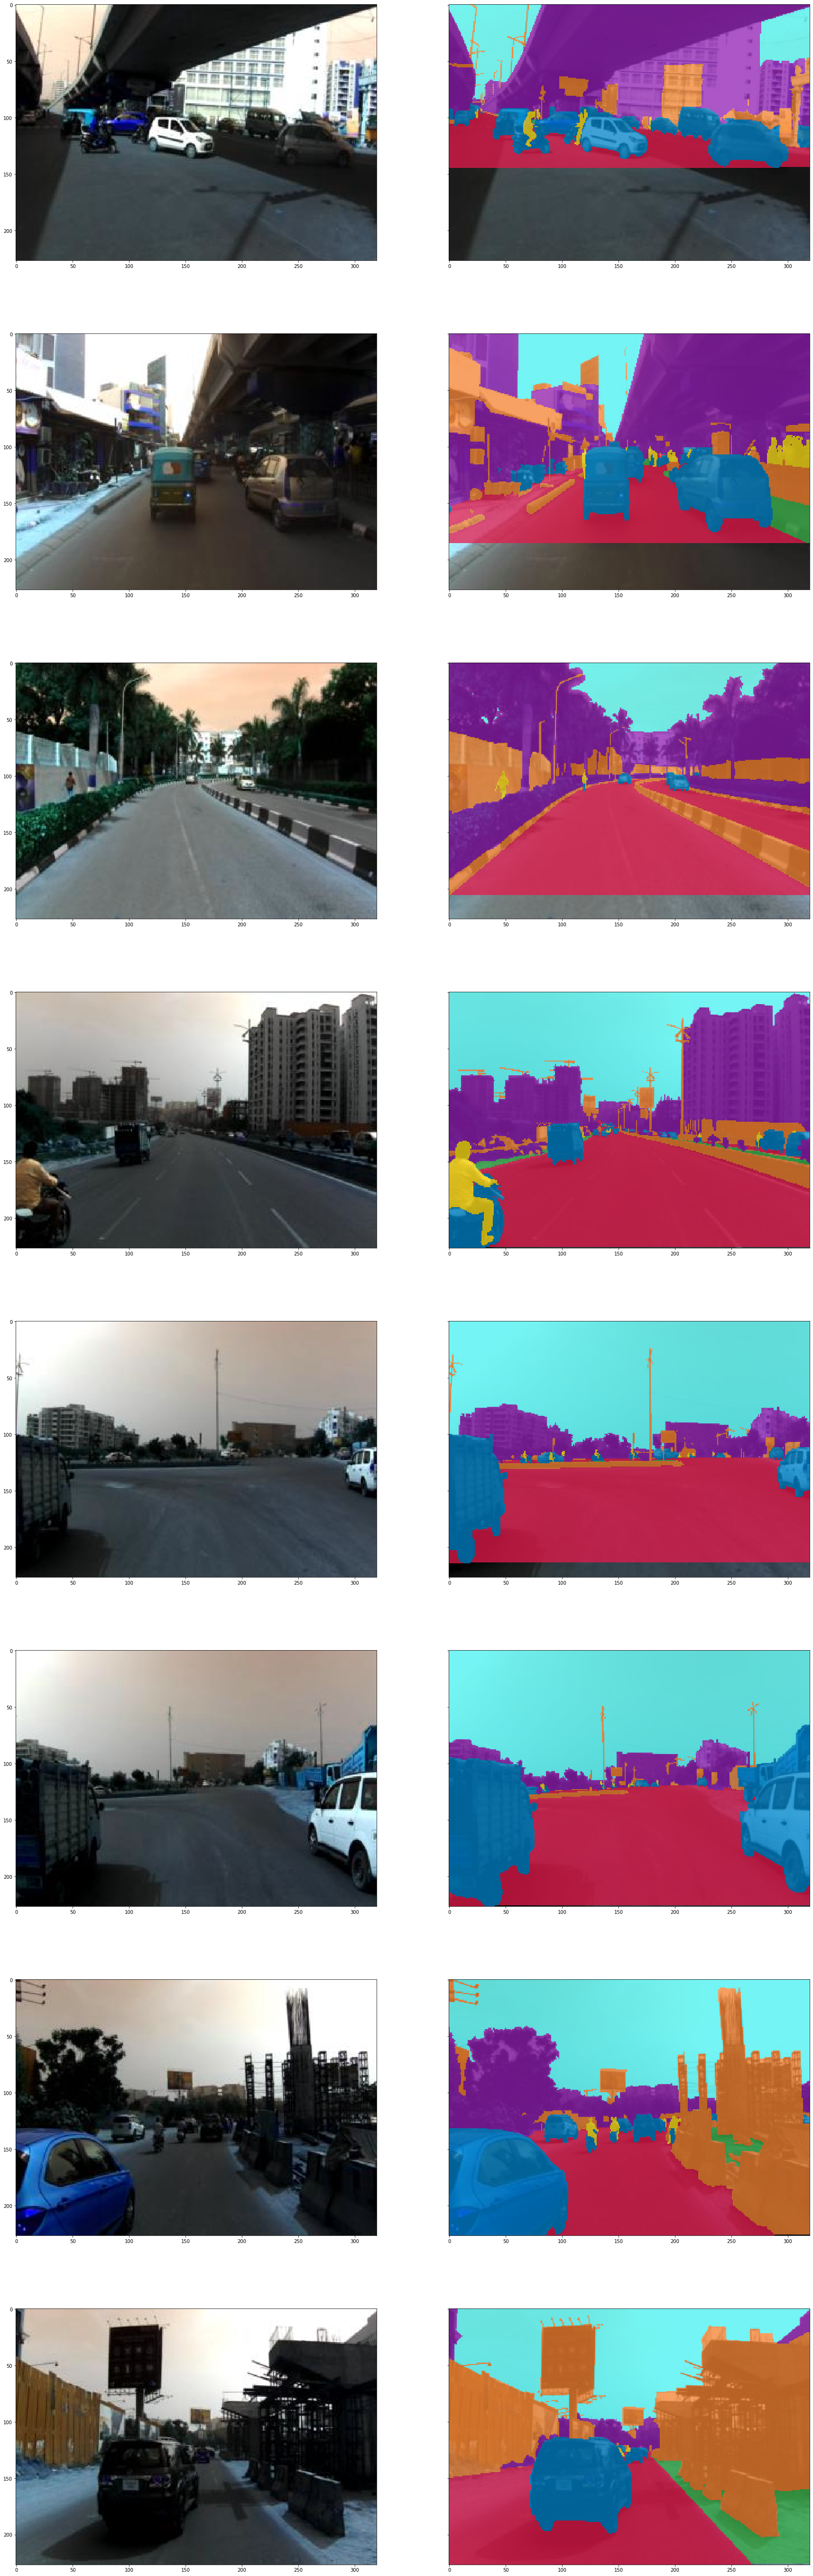

In [14]:
fig, ax = plt.subplots(nrows=8, ncols=2, sharey=True, figsize=(30,100))
img_id=500
for i,id in enumerate(range(img_id,img_id+8)):
    img = cv2.imread(train_fns[id])
    h,w,c=img.shape
    ax[i][0].imshow(img)
    ax[i][1].imshow(create_segmentation_overlay(id))

In [15]:
#need to complete the histogram plotting for class distribution, box plots
#pearson correlation between the classes

We need to understand which are the classes which are generally occuring together.
I will use Frequency Mining pattern algorithm

In [16]:
label_per_image = grouped_EncodedPixels.apply(lambda encoded_list: [x[0] for x in encoded_list if x[1] != -1])

In [17]:
# create a list of dict with count of each fault class
label_per_image_list = []
for r in label_per_image.iteritems():
    label_count = {'0':0,'1':0,'2':0,'3':0,'4':0,'5':0,'6':0,'255':0}
    # go over each class and 
    #print(r)
    for image_label in r[1]:
        label_count[str(image_label)] = 1
    #print(label_count)
    label_per_image_list.append(label_count)

Surface Area Ratio for each mask 
---------------------------------------------
If a mask occupies less area, the sensitivity of the model to segment it would be low. Trying to plot the surface area graph for each of the masks 


In [18]:
def get_binary_mask_sum(encoded_mask):
    if(encoded_mask==-1):
        return 0
    mask_decoded = rle2mask(encoded_mask, 227, 320)
    binary_mask = (mask_decoded > 0.0).astype(int)
    return binary_mask.sum()

In [19]:
# calculate sum of the pixels for the mask per cloud formation
train_df['mask_pixel_sum'] = train_df.apply(lambda x: get_binary_mask_sum(x['EncodedPixels']), axis=1)

In [21]:
# plot a histogram and boxplot combined of the mask pixel sum per cloud formation
fig = px.histogram(train_df[train_df['mask_pixel_sum']!=0][['ClassId','mask_pixel_sum']], 
                   x="mask_pixel_sum", y="ClassId", color="ClassId", marginal="box")

fig['layout'].update(title='Histogram and Boxplot of Sum of IDD Masks')

fig.show()

Analysis
----------------------------------------------------------
mask_per_pixel_sum denotes the mask surface area for each of the classes. 
Most of the images have entire mask region segmented by the dataset constructiors, For the regions with >40K only class 5 information is given. Only building /bridge/tunnel segmented, not background. However, count is low , so perhaps can take it during the trai ning process. 

227*320=72640 of which 10% would be roughly 7k. Most of the mask surface area lies in the 0-10% region of the image. So the majority of the dataset has not been properly segmented. (Otherwise the sum of majority masks would have shifted to right )

Background Class
---------------------------------------------------------------------
There are very less number of pixels corresponding to the background class. (Can take low weights in the inmage)

* Take the notion of class average/weighing from this graph. (The backgorund is gonna be least important).
* Direct the attention of the network to the class with the maximum mask area.(on the average, not total)